# Results Section: Germany vs US Cookie Consent Analysis

This notebook produces the values for the **Results** section of our paper. It compares cookie consent interfaces between Germany and US traffic using Consent Observatory scraper data.

**Data sources**: `tranco_germany.json` (Germany) and `tranco_us.json` (US).

## 1. Setup and Data Loading

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from urllib.parse import urlparse

# data paths
DATA_DIR = Path(r'../data/')
EXAMPLES_DIR = DATA_DIR / 'examples'
OUTPUT_DIR = DATA_DIR / 'output'

# --- Academic plot style ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (7, 4),           # good for single column
    'figure.dpi': 150,                  # high quality display
    'savefig.dpi': 300,                 # publication quality export
    'font.size': 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.spines.top': False,           # clean look
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.family': 'sans-serif',
})

# Colorblind-friendly palette (Okabe-Ito)
COLORS = {'Germany': '#0072B2', 'US': '#D55E00'}  # blue and vermillion

print("Setup complete.")

Setup complete.


### 1.1 Load Data

In [ ]:
def load_records_from_json_file(json_path):
    records = []
    with open(json_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                records.append(json.loads(line))
    return records

# --- Load data ---
all_eu_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco-germany.json')
all_us_records = load_records_from_json_file(EXAMPLES_DIR / 'tranco-us.json')

print(f"All Germany records: {len(all_eu_records)}")
print(f"All US records: {len(all_us_records)}")

FileNotFoundError: [Errno 2] No such file or directory: '..\\data\\examples\\tranco_germany.json'

### 1.2 Common Websites Filter

Restrict the dataset to websites that retrieved succesfully in both Germany and US crawls. This ensures a fair comparison between regions.

In [ ]:
# find common websites and filter
eu_urls = {r.get('url') for r in all_eu_records}
us_urls = {r.get('url') for r in all_us_records}
common_urls = eu_urls & us_urls

eu_records = [r for r in all_eu_records if r.get('url') in common_urls]
us_records = [r for r in all_us_records if r.get('url') in common_urls]

n_eu_before, n_us_before = len(all_eu_records), len(all_us_records)
n_eu_after, n_us_after = len(eu_records), len(us_records)

# table: dataset length change after common-websites filter
dataset_change = pd.DataFrame({
    'Location': ['Germany', 'US'],
    'Before (records)': [n_eu_before, n_us_before],
    'After (records)': [n_eu_after, n_us_after],
    'Dropped': [n_eu_before - n_eu_after, n_us_before - n_us_after],
})

print(f"Common websites: {len(common_urls)}")
us_urls

Common websites: 744


{'https://123av.com',
 'https://163.com',
 'https://3bmeteo.com',
 'https://3ckz.com',
 'https://3lift.com',
 'https://52shuku.net',
 'https://69shuba.com',
 'https://a-mo.net',
 'https://aajtak.in',
 'https://abc.es',
 'https://abc.net.au',
 'https://academia.edu',
 'https://accuweather.com',
 'https://acesso.gov.br',
 'https://actu.fr',
 'https://adblockplus.org',
 'https://addtoany.com',
 'https://adobe.io',
 'https://adsrvr.org',
 'https://aftonbladet.se',
 'https://agoda.com',
 'https://airbnb.com',
 'https://ak2yy.com',
 'https://alibaba.com',
 'https://aliexpress.com',
 'https://aliyun.com',
 'https://allocine.fr',
 'https://alphonso.tv',
 'https://amazon.ca',
 'https://amazon.co.uk',
 'https://amazon.com.au',
 'https://amazon.com.br',
 'https://amazon.com.mx',
 'https://amazon.de',
 'https://amazon.es',
 'https://amazon.fr',
 'https://amazon.in',
 'https://amazontrust.com',
 'https://ameba.jp',
 'https://ameblo.jp',
 'https://amplitude.com',
 'https://amt3.com',
 'https://amzn.

### 1.3 Inspect JSON Structure

In [ ]:
# --- Inspect JSON structure ---

# let's select the first record
sample = eu_records[0]

print("Top-level keys:", list(sample.keys()))
print("data gatherers:", list((sample.get('data')).keys()))
print(*("--------" for i in range(10)))

# gatherers = ['ScreenshotGatherer','DOMGatherer', 'CookieGatherer',
#             'WordBoxGatherer', 'IABJSGatherer', 'EventListenerGatherer',
#             'ButtonGatherer', 'NormalizedWordButtonGatherer',
#             'VisibilityAnalyzer', 'CheckboxGatherer', 'CMPGatherer']
gatherers = list((sample.get('data')).keys())

for gatherer in gatherers:
    gatherer_data = (sample.get('data')).get(gatherer)
    if not gatherer_data:
        print(f"***{gatherer} is empty")
        continue
    gatherer_keys = list(gatherer_data.keys())
    print(f"--> {gatherer}: {gatherer_keys}")

Top-level keys: ['time', 'url', 'requestStrategy', 'data']
data gatherers: ['ScreenshotGatherer', 'DOMGatherer', 'CookieGatherer', 'WordBoxGatherer', 'IABJSGatherer', 'EventListenerGatherer', 'ButtonGatherer', 'NormalizedWordButtonGatherer', 'VisibilityAnalyzer', 'CheckboxGatherer', 'CMPGatherer']
-------- -------- -------- -------- -------- -------- -------- -------- -------- --------
--> ScreenshotGatherer: ['onDomContentLoaded', 'onPageWait']
--> DOMGatherer: ['dom']
--> CookieGatherer: ['cookies']
--> WordBoxGatherer: ['hits', 'potentialAnchors', 'filteredAnchors', 'filteredFrames', 'detections']
--> IABJSGatherer: ['tcfapiDetected', 'pingResult']
--> EventListenerGatherer: ['detections', 'detectionsArray']
--> ButtonGatherer: ['detections', 'detectionsArray']
--> NormalizedWordButtonGatherer: ['detections', 'detectionsArray']
***VisibilityAnalyzer is empty
--> CheckboxGatherer: ['detections', 'detectionsArray']
--> CMPGatherer: ['CMPs']


## 3. Cookie Analysis

### 3.1 Extract CookieGatherer Data

In [ ]:
def extract_cookies_to_csv(website_data_list, output_filename):
    # Define the column headers for the CSV
    headers = [
        'website_url', 'cookie_name', 'value', 'domain', 'path', 'expires', 
        'size', 'httpOnly', 'secure', 'session', 'sameSite', 
        'priority', 'sameParty', 'sourceScheme', 'sourcePort'
    ]
    
    # Open the file and set up the writer
    with open(output_filename, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=headers, delimiter=';')
        writer.writeheader()
        
        # Iterate through each website's data object
        for site_data in website_data_list:
            url = site_data.get('url', 'Unknown URL')
            
            data_block = site_data.get('data', {})
            cookie_gatherer = data_block.get('CookieGatherer', {})
            cookies = cookie_gatherer.get('cookies', [])
            
            # Loop through each cookie in the list and write it to the CSV
            for cookie in cookies:
                row = {
                    'website_url': url,
                    'cookie_name': cookie.get('name', ''),
                    'value': cookie.get('value', ''),
                    'domain': cookie.get('domain', ''),
                    'path': cookie.get('path', ''),
                    'expires': cookie.get('expires', ''),
                    'size': cookie.get('size', ''),
                    'httpOnly': cookie.get('httpOnly', ''),
                    'secure': cookie.get('secure', ''),
                    'session': cookie.get('session', ''),
                    'sameSite': cookie.get('sameSite', ''), 
                    'priority': cookie.get('priority', ''),
                    'sameParty': cookie.get('sameParty', ''),
                    'sourceScheme': cookie.get('sourceScheme', ''),
                    'sourcePort': cookie.get('sourcePort', '')
                }
                writer.writerow(row)

# extract cookies to csv
extract_cookies_to_csv(eu_records, OUTPUT_DIR / 'eu_cookies.csv')
extract_cookies_to_csv(us_records, OUTPUT_DIR / 'us_cookies.csv')
print(f"Successfully extracted cookies from Germany and US records. Files saved under {OUTPUT_DIR}")

Successfully extracted cookies from Germany and US records. Files saved under ..\data\output


In [ ]:
df_eu_cookies = pd.read_csv(OUTPUT_DIR / 'eu_cookies.csv', sep=';')
df_us_cookies = pd.read_csv(OUTPUT_DIR / 'us_cookies.csv', sep=';')

# let's check the cookies dataframe for EU
df_us_cookies.head()

,website_url,cookie_name,value,domain,path,expires,size,httpOnly,secure,session,sameSite,priority,sameParty,sourceScheme,sourcePort
0,https://icloud.com,x-apple-group,false,www.icloud.com,/,-1.000000e+00,18,True,True,True,NaN,Medium,False,Secure,443
1,https://wikipedia.org,WMF-Last-Access,21-Feb-2026,wikipedia.org,/,1.774460e+09,26,True,True,False,NaN,Medium,False,Secure,443
2,https://wikipedia.org,WMF-Last-Access-Global,21-Feb-2026,.wikipedia.org,/,1.774460e+09,33,True,True,False,NaN,Medium,False,Secure,443
3,https://wikipedia.org,GeoIP,US:UT:Salt_Lake_City:40.76:-111.89:v4,.wikipedia.org,/,-1.000000e+00,42,False,True,True,NaN,Medium,False,Secure,443
4,https://wikipedia.org,NetworkProbeLimit,0.001,wikipedia.org,/,1.771716e+09,22,False,True,False,NaN,Medium,False,Secure,443


### 3.2 Filter to Common Websites

Compare what websites have CookieGatherer data for both locations, then restrict the analysis to common websites only.

In [ ]:
# # get unique websites from both dataframes
# eu_websites = set(df_eu_cookies['website_url'])
# us_websites = set(df_us_cookies['website_url'])

# # websites in EU but NOT in US
# eu_only_websites = eu_websites - us_websites
# print(f"Number of websites ONLY in EU dataset: {len(eu_only_websites)}")
# print(eu_only_websites)

# # websites in US but NOT in EU
# us_only_websites = us_websites - eu_websites
# print(f"Number of websites ONLY in US dataset: {len(us_only_websites)}")
# print(us_only_websites)

# common_websites = eu_websites & us_websites

# # Update DataFrames to keep only rows where the URL is in our common set
# df_eu_cookies = df_eu_cookies[df_eu_cookies['website_url'].isin(common_websites)]
# df_us_cookies = df_us_cookies[df_us_cookies['website_url'].isin(common_websites)]

# # Print the new row counts to verify it worked
# print(f"Updated EU cookies dataset size: {len(df_eu_cookies)} cookies")
# print(f"Updated US cookies dataset size: {len(df_us_cookies)} cookies")


### 3.3 Plot Cookie Count Distribution

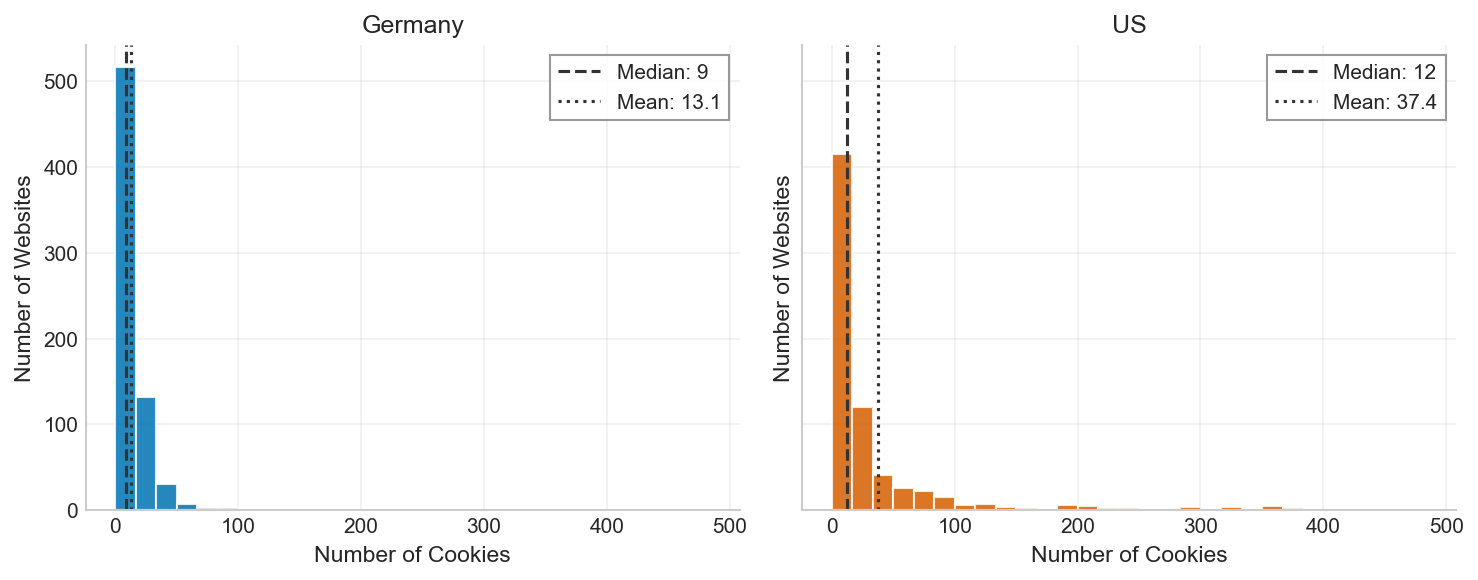

Germany - Mean: 13.1, Median: 9, Max: 159
US - Mean: 37.4, Median: 12, Max: 484


In [ ]:
# cookies per website distribution
eu_cookies_per_site = df_eu_cookies.groupby('website_url').size()
us_cookies_per_site = df_us_cookies.groupby('website_url').size()

# Calculate common bins so bar widths match
global_max = max(eu_cookies_per_site.max(), us_cookies_per_site.max())
common_bins = np.linspace(0, global_max, 30)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Germany histogram
axes[0].hist(eu_cookies_per_site, bins=common_bins, color=COLORS['Germany'], edgecolor='white', alpha=0.85)
axes[0].set_xlabel('Number of Cookies')
axes[0].set_ylabel('Number of Websites')
axes[0].set_title('Germany')
axes[0].axvline(eu_cookies_per_site.median(), color='#333333', linestyle='--', linewidth=1.5, label=f'Median: {eu_cookies_per_site.median():.0f}')
axes[0].axvline(eu_cookies_per_site.mean(), color='#333333', linestyle=':', linewidth=1.5, label=f'Mean: {eu_cookies_per_site.mean():.1f}')
axes[0].legend(frameon=True, fancybox=False, edgecolor='gray')

# US histogram
axes[1].hist(us_cookies_per_site, bins=common_bins, color=COLORS['US'], edgecolor='white', alpha=0.85)
axes[1].set_xlabel('Number of Cookies')
axes[1].set_ylabel('Number of Websites')
axes[1].set_title('US')
axes[1].axvline(us_cookies_per_site.median(), color='#333333', linestyle='--', linewidth=1.5, label=f'Median: {us_cookies_per_site.median():.0f}')
axes[1].axvline(us_cookies_per_site.mean(), color='#333333', linestyle=':', linewidth=1.5, label=f'Mean: {us_cookies_per_site.mean():.1f}')
axes[1].legend(frameon=True, fancybox=False, edgecolor='gray')

plt.tight_layout()
plt.show()

# summary stats
print(f"Germany - Mean: {eu_cookies_per_site.mean():.1f}, Median: {eu_cookies_per_site.median():.0f}, Max: {eu_cookies_per_site.max()}")
print(f"US - Mean: {us_cookies_per_site.mean():.1f}, Median: {us_cookies_per_site.median():.0f}, Max: {us_cookies_per_site.max()}")

### 3.4 Top 10 Websites with Most Cookies

In [ ]:
# calculate the base counts
eu_counts = df_eu_cookies['website_url'].value_counts().reset_index()
eu_counts.columns = ['website', 'count_eu']

us_counts = df_us_cookies['website_url'].value_counts().reset_index()
us_counts.columns = ['website', 'count_us']

# create the MOST cookies table
# get top 10, then reset index so they align perfectly
eu_most = eu_counts.head(10)[['website', 'count_eu']].reset_index(drop=True)
us_most = us_counts.head(10)[['website', 'count_us']].reset_index(drop=True)

eu_most.columns = ['Germany Most', 'Count']
us_most.columns = ['US Most', 'Count']

# combine horizontally
most_cookies_table = pd.concat([eu_most, us_most], axis=1)
most_cookies_table.index = range(1, 11)
most_cookies_table.index.name = 'Rank'

display(most_cookies_table)

,Germany Most,Count,US Most,Count
Rank,,,,
1,https://ficbook.net,159,https://jagran.com,484
2,https://avito.ru,127,https://clarin.com,452
3,https://livejournal.com,109,https://genius.com,381
4,https://carsensor.net,90,https://merkur.de,373
5,https://macys.com,87,https://huffpost.com,369
6,https://mlb.com,84,https://livehindustan.com,366
7,https://rakuten.co.jp,77,https://huffingtonpost.com,361
8,https://hbr.org,70,https://independent.co.uk,357
9,https://pendo.io,68,https://kooora.com,356


### 3.5 Cookie Difference Comparison (Germany vs US)

In [ ]:
# merge all counts, fill missing with 0
merged = pd.merge(eu_counts, us_counts, on='website', how='outer').fillna(0)

# calculate where Germany has more cookies
eu_more = merged[merged['count_eu'] > merged['count_us']].copy()
eu_more['diff'] = (eu_more['count_eu'] - eu_more['count_us']).astype(int)
eu_more_top = eu_more.sort_values(by='diff', ascending=False)[['website', 'diff']].head(10).reset_index(drop=True)
eu_more_top.columns = ['Germany Has More Cookies', 'Diff']

# calculate where US has more
us_more = merged[merged['count_us'] > merged['count_eu']].copy()
us_more['diff'] = (us_more['count_us'] - us_more['count_eu']).astype(int)
us_more_top = us_more.sort_values(by='diff', ascending=False)[['website', 'diff']].head(10).reset_index(drop=True)
us_more_top.columns = ['US Has More Cookies', 'Diff']

# combine differences
diff_table = pd.concat([eu_more_top, us_more_top], axis=1)
diff_table.index = range(1, 11)
diff_table.index.name = 'Rank'

display(diff_table)

,Germany Has More Cookies,Diff,US Has More Cookies,Diff
Rank,,,,
1,https://meraki.com,33,https://jagran.com,472
2,https://mydramalist.com,31,https://clarin.com,420
3,https://myntra.com,29,https://genius.com,371
4,https://livejournal.com,28,https://merkur.de,365
5,https://xnxx.health,27,https://huffpost.com,360
6,https://savefrom.net,20,https://huffingtonpost.com,353
7,https://amazon.ca,19,https://kooora.com,346
8,https://sportradar.com,19,https://britannica.com,341
9,https://amazon.com.au,18,https://livehindustan.com,333


### 3.6 First-Party vs Third-Party Cookies

Distribution of first-party vs third-party cookies for Germany and US traffic.

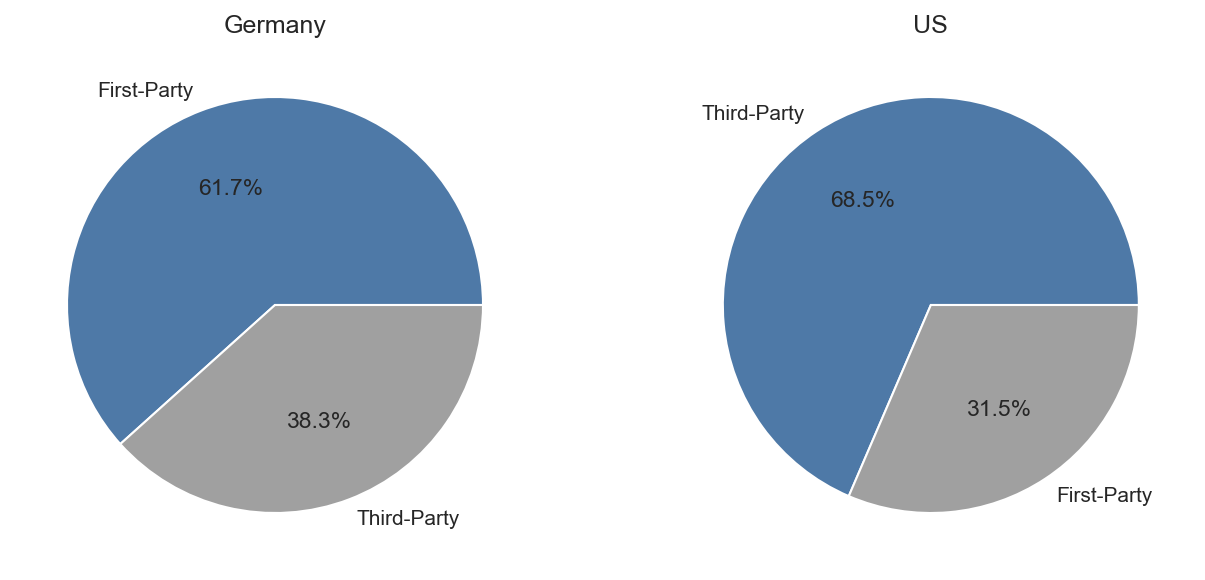

In [ ]:
def categorize_party(row):
    # extract the hostname from the website_url and remove 'www.' if present
    url_host = str(urlparse(row['website_url']).hostname).removeprefix('www.')
    
    # clean the cookie domain by removing leading dots AND 'www.' if present
    cookie_domain = str(row['domain']).lstrip('.').removeprefix('www.')
    
    # if it's an exact match OR a valid subdomain match, it's First-Party
    if url_host == cookie_domain or url_host.endswith('.' + cookie_domain):
        return 'First-Party'
    else:
        return 'Third-Party'

# this creates a new column called 'party', first-party/third-party
df_eu_cookies['party'] = df_eu_cookies.apply(categorize_party, axis=1)
df_us_cookies['party'] = df_us_cookies.apply(categorize_party, axis=1)

# count the occurrences
eu_party_counts = df_eu_cookies['party'].value_counts()
us_party_counts = df_us_cookies['party'].value_counts()

# plot pie charts with academic styling
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
pie_colors = ['#4E79A7', '#A0A0A0']  # muted blue and gray

# Plot Germany
axes[0].pie(eu_party_counts, 
            labels=eu_party_counts.index, 
            autopct='%1.1f%%',
            colors=pie_colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1})
axes[0].set_title('Germany')

# Plot US
axes[1].pie(us_party_counts, 
            labels=us_party_counts.index, 
            autopct='%1.1f%%',
            colors=pie_colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1})
axes[1].set_title('US')

plt.tight_layout()
plt.show()

## 4. Consent Button Analysis

### 4.1 Extract Normalized Buttons

In [ ]:
def extract_normalized_buttons_to_csv(website_data_list, output_filename='website_buttons.csv'):
    # Define the column headers, including flattened visibility analysis fields
    headers = [
        'website_url', 'text', 'normalized', 'element', 'category', 'distance', 'popup',
        'vis_color', 'vis_backgroundColor', 'vis_fontSize', 'vis_fontWeight', 
        'vis_clickability', 'vis_score'
    ]
    
    with open(output_filename, mode='w', newline='', encoding='utf-8') as csv_file:
        # Using semicolon delimiter for European Excel compatibility
        writer = csv.DictWriter(csv_file, fieldnames=headers, delimiter=';')
        writer.writeheader()
        
        for site_data in website_data_list:
            url = site_data.get('url', 'Unknown URL')
            
            # Safely navigate to the NormalizedWordButtonGatherer array
            data_block = site_data.get('data', {})
            button_gatherer = data_block.get('NormalizedWordButtonGatherer', {})
            detections_array = button_gatherer.get('detectionsArray', [])
            
            # Loop through each detected button
            for detection in detections_array:
                # The visibility data is nested, so we pull it out first
                vis_analysis = detection.get('visibilityAnalysis', {})
                
                row = {
                    'website_url': url,
                    'text': detection.get('text', ''),
                    'normalized': detection.get('normalized', ''),
                    'element': detection.get('element', ''),
                    'category': detection.get('category', ''),
                    'distance': detection.get('distance', ''),
                    'popup': detection.get('popup', ''),
                    
                    # Flattened visibility metrics
                    'vis_color': vis_analysis.get('color', ''),
                    'vis_backgroundColor': vis_analysis.get('backgroundColor', ''),
                    'vis_fontSize': vis_analysis.get('fontSize', ''),
                    'vis_fontWeight': vis_analysis.get('fontWeight', ''),
                    'vis_clickability': vis_analysis.get('clickability', ''),
                    'vis_score': vis_analysis.get('score', '')
                }
                writer.writerow(row)

# extract noramlized buttons to csv                
extract_normalized_buttons_to_csv(eu_records, OUTPUT_DIR / 'eu_normalized_buttons.csv')
extract_normalized_buttons_to_csv(us_records, OUTPUT_DIR / 'us_normalized_buttons.csv')
print(f"Successfully extracted normalized buttons from Germany and US records. Files saved under {OUTPUT_DIR}")

Successfully extracted normalized buttons from Germany and US records. Files saved under ..\data\output


In [ ]:
df_eu_normalized_buttons = pd.read_csv(OUTPUT_DIR / 'eu_normalized_buttons.csv', sep=';')
df_us_normalized_buttons = pd.read_csv(OUTPUT_DIR / 'us_normalized_buttons.csv', sep=';')

# let's check the normalized buttons dataframe for EU
df_eu_normalized_buttons.head()

,website_url,text,normalized,element,category,distance,popup,vis_color,vis_backgroundColor,vis_fontSize,vis_fontWeight,vis_clickability,vis_score
0,https://instagram.com,nb,ne,"<option value=""nb"">Norsk</option>",2,1,0,"rgb(28, 30, 33)","rgba(0, 0, 0, 0)",12px,400.0,0.0,-0.500000
1,https://instagram.com,nl,ne,"<option value=""nl"">Nederlands</option>",2,1,0,"rgb(28, 30, 33)","rgba(0, 0, 0, 0)",12px,400.0,0.0,-0.500000
2,https://instagram.com,ne,ne,"<option value=""ne"">नेपाली</option>",2,0,0,"rgb(28, 30, 33)","rgba(0, 0, 0, 0)",12px,400.0,0.0,-0.500000
3,https://netflix.com,Learn more,learnmore→,"<button id=""onetrust-pc-btn-handler"" aria-labe...",3,1,0,"rgb(51, 51, 51)","rgb(255, 255, 255)",13.008px,600.0,1.0,0.418980
4,https://netflix.com,Reject,reject,"<button id=""onetrust-reject-all-handler"">Rejec...",2,0,0,"rgb(255, 255, 255)","rgb(229, 9, 20)",13.008px,600.0,1.0,1.428698


In [ ]:
# sort by website_url, then category, then vis_score (descending so the highest is first)
df_eu_normalized_buttons = df_eu_normalized_buttons.sort_values(by=['website_url', 'category', 'vis_score'], ascending=[True, True, False])
df_us_normalized_buttons = df_us_normalized_buttons.sort_values(by=['website_url', 'category', 'vis_score'], ascending=[True, True, False])

# drop the duplicates, keeping the first (highest vis_score) row for each category on each URL
df_eu_normalized_buttons_cleaned = df_eu_normalized_buttons.drop_duplicates(subset=['website_url', 'category'], keep='first')
df_us_normalized_buttons_cleaned = df_us_normalized_buttons.drop_duplicates(subset=['website_url', 'category'], keep='first')

# save the cleaned dataframes to new CSV files
df_eu_normalized_buttons_cleaned.to_csv(Path(OUTPUT_DIR / 'eu_normalized_buttons_cleaned.csv'), index=False)
df_us_normalized_buttons_cleaned.to_csv(Path(OUTPUT_DIR / 'us_normalized_buttons_cleaned.csv'), index=False)

# compare how button count changed after cleaning
print(f"Germany - Total buttons before cleaning: {len(df_eu_normalized_buttons)}, after cleaning: {len(df_eu_normalized_buttons_cleaned)}")
print(f"US - Total buttons before cleaning: {len(df_us_normalized_buttons)}, after cleaning: {len(df_us_normalized_buttons_cleaned)}")

Germany - Total buttons before cleaning: 20267, after cleaning: 1025
US - Total buttons before cleaning: 917, after cleaning: 533


### 4.2 Button Existence Matrix

In [ ]:
# create a function to build the 1/0 matrix (to show if a specific button category exists or not)
def get_button_existence(df):
    # crosstab counts occurrences, but we just want to know if it's > 0
    matrix = pd.crosstab(df['website_url'], df['category'])
    
    # Convert counts to 1 (Exists) or 0 (Does not exist)
    existence_df = (matrix > 0).astype(int)
    return existence_df

# Apply to your button dataframes (replace with your actual dataframe names if different)
eu_button_exist = get_button_existence(df_eu_normalized_buttons_cleaned)
us_button_exist = get_button_existence(df_us_normalized_buttons_cleaned)

print("Germany Button Existence Matrix (Preview)")
display(eu_button_exist.head())

Germany Button Existence Matrix (Preview)


category,1,2,3,4,5
website_url,,,,,
https://3bmeteo.com,1,0,1,0,0
https://3lift.com,1,1,1,1,0
https://aajtak.in,1,0,1,0,0
https://abc.es,1,0,1,0,1
https://actu.fr,1,1,1,0,0


### 4.3 Button Category Distribution

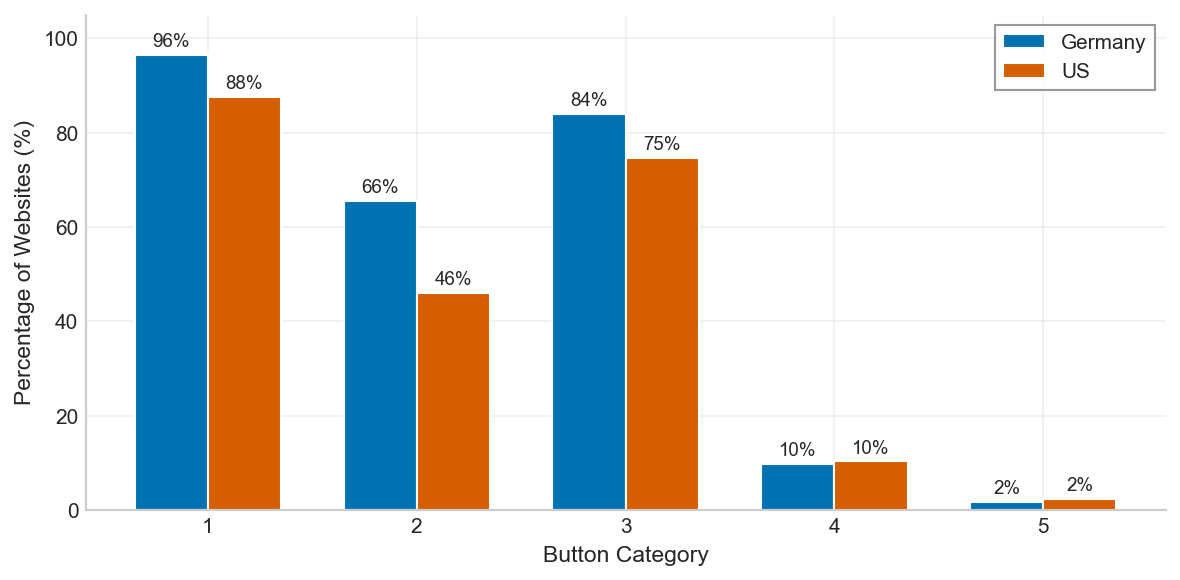

In [ ]:
# calculate percentage of websites that have each button
eu_btn_pct = (eu_button_exist.mean() * 100).rename('Germany')
us_btn_pct = (us_button_exist.mean() * 100).rename('US')

# combine into one table and fill missing categories with 0
btn_comparison = pd.concat([eu_btn_pct, us_btn_pct], axis=1).fillna(0)

# plot the comparison
categories = btn_comparison.index
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

bars_eu = ax.bar(x - width/2, btn_comparison['Germany'], width, label='Germany', color=COLORS['Germany'], edgecolor='white')
bars_us = ax.bar(x + width/2, btn_comparison['US'], width, label='US', color=COLORS['US'], edgecolor='white')

ax.set_ylabel('Percentage of Websites (%)')
ax.set_xlabel('Button Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim(0, 105)
ax.legend(frameon=True, fancybox=False, edgecolor='gray')

# add percentage values on top
for bars in [bars_eu, bars_us]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.0f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 4.4 Most Common Button Normalized Texts by Category

In [ ]:
# category labels
cat_labels = {1: 'Accept', 2: 'Reject', 3: 'Settings', 4: 'Save', 5: 'Other'}

def get_top_labels_by_category(df, category, top_n=5):
    """Get top N most common button labels for a given category (counts)."""
    cat_df = df[df['category'] == category]
    counts = cat_df['normalized'].value_counts()
    return counts.head(top_n)

# Create tables for each category
for cat, cat_name in cat_labels.items():
    eu_top = get_top_labels_by_category(df_eu_normalized_buttons_cleaned, cat, 5)
    us_top = get_top_labels_by_category(df_us_normalized_buttons_cleaned, cat, 5)
    
    # Build table with Germany and US side by side
    eu_data = pd.DataFrame({
        'Germany Label': eu_top.index,
        'Germany Count': eu_top.values
    }).reset_index(drop=True)
    
    us_data = pd.DataFrame({
        'US Label': us_top.index,
        'US Count': us_top.values
    }).reset_index(drop=True)
    
    table = pd.concat([eu_data, us_data], axis=1)
    table.index = range(1, len(table) + 1)
    table.index.name = 'Rank'
    
    print(f"\n{'='*60}")
    print(f"  {cat_name} Button Labels (Top 5)")
    print(f"{'='*60}")
    display(table)


  Accept Button Labels (Top 5)


,Germany Label,Germany Count,US Label,US Count
Rank,,,,
1,accept,75,acceptall,34
2,acceptall,73,accept,24
3,acceptallcookies,45,ok,23
4,consent,43,acceptallcookies,19
5,alleakzeptieren,15,acceptcookies,11



  Reject Button Labels (Top 5)


,Germany Label,Germany Count,US Label,US Count
Rank,,,,
1,rejectall,76,rejectall,28
2,reject,33,decline,8
3,rejectallcookies,11,donotsellorsharemypersonalinformation,8
4,alleablehnen,10,deny,7
5,ablehnen,10,reject,5



  Settings Button Labels (Top 5)


,Germany Label,Germany Count,US Label,US Count
Rank,,,,
1,cookiessettings,44,cookiessettings,27
2,manageoptions,36,learnmore→,22
3,managecookies,32,managepreferences,14
4,showpurposes,17,managecookies,8
5,customize,16,customize,8



  Save Button Labels (Top 5)


,Germany Label,Germany Count,US Label,US Count
Rank,,,,
1,save,7,savepreferences,6
2,savepreferences,6,save,5
3,allowselectedcookies,6,allowselectedcookies,4
4,allowselection,5,allowselection,3
5,savesettings,3,confirmmychoices,2



  Other Button Labels (Top 5)


,Germany Label,Germany Count,US Label,US Count
Rank,,,,
1,werbefreifur299monat,2,rechazarysuscribirse,2
2,rechazarysuscribirse,2,rechazarypagar,1
3,rechazarypagar,1,werbefreifur299monat,1
4,jemabonne,1,jemabonne,1
5,refuseretsabonner199pouruneexperiencesanspub→,1,refuseretsabonner199pouruneexperiencesanspub→,1


## 5. Consent Interface Analysis

### 5.1 Banner Presence Overview

**Question:** How many websites simply don't show a consent interface at all to US visitors?

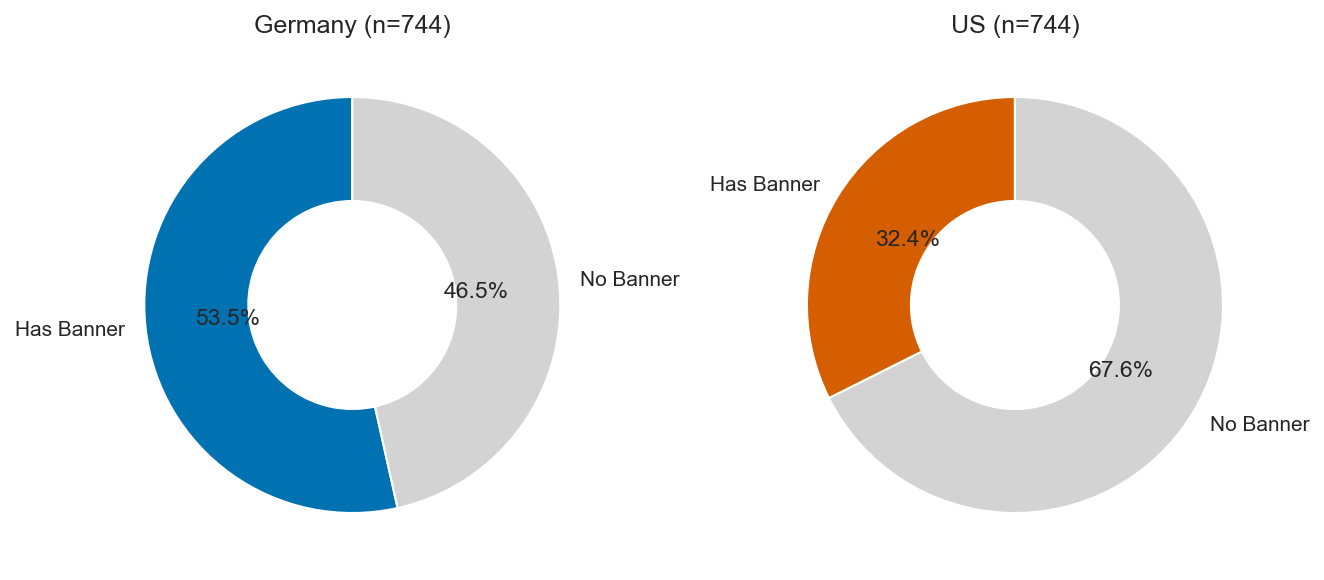

Germany: 398/744 (53.5%) websites have consent banner
US: 241/744 (32.4%) websites have consent banner
Banner drop in US: 21.1 percentage points


In [ ]:
# Donut chart: Presence of consent interface (any buttons detected)
eu_with_banner = df_eu_normalized_buttons['website_url'].nunique()
us_with_banner = df_us_normalized_buttons['website_url'].nunique()
eu_total = len(eu_records)
us_total = len(us_records)

eu_no_banner = eu_total - eu_with_banner
us_no_banner = us_total - us_with_banner

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Germany donut
eu_sizes = [eu_with_banner, eu_no_banner]
eu_labels = ['Has Banner', 'No Banner']
colors_eu = [COLORS['Germany'], '#D3D3D3']
wedges, texts, autotexts = axes[0].pie(eu_sizes, labels=eu_labels, autopct='%1.1f%%',
                                        colors=colors_eu, startangle=90,
                                        wedgeprops=dict(width=0.5, edgecolor='white'))
axes[0].set_title(f'Germany (n={eu_total})')

# US donut
us_sizes = [us_with_banner, us_no_banner]
us_labels = ['Has Banner', 'No Banner']
colors_us = [COLORS['US'], '#D3D3D3']
wedges, texts, autotexts = axes[1].pie(us_sizes, labels=us_labels, autopct='%1.1f%%',
                                        colors=colors_us, startangle=90,
                                        wedgeprops=dict(width=0.5, edgecolor='white'))
axes[1].set_title(f'US (n={us_total})')

plt.tight_layout()
plt.show()

print(f"Germany: {eu_with_banner}/{eu_total} ({eu_with_banner/eu_total*100:.1f}%) websites have consent banner")
print(f"US: {us_with_banner}/{us_total} ({us_with_banner/us_total*100:.1f}%) websites have consent banner")
print(f"Banner drop in US: {(eu_with_banner/eu_total - us_with_banner/us_total)*100:.1f} percentage points")

### 5.3 The "Disappearing" Reject Button

**Question:** Are websites more likely to hide or remove the "Reject" button for US visitors compared to German visitors?

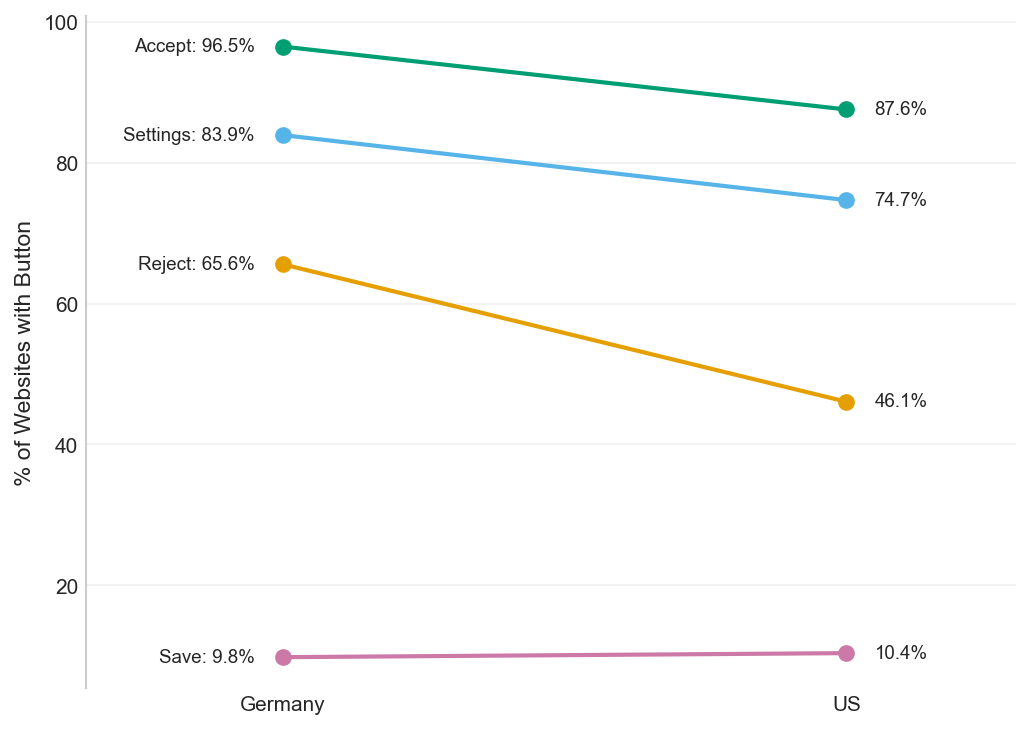

Reject button presence: Germany=65.6%, US=46.1%
Reject button drop: 19.5 percentage points


In [ ]:
# Slopegraph: Button presence by category (Germany vs US)
cat_labels = {1: 'Accept', 2: 'Reject', 3: 'Settings', 4: 'Save'}

# Calculate percentage of websites with each button type
eu_pcts = {cat: eu_button_exist[cat].mean() * 100 if cat in eu_button_exist.columns else 0 
           for cat in cat_labels.keys()}
us_pcts = {cat: us_button_exist[cat].mean() * 100 if cat in us_button_exist.columns else 0 
           for cat in cat_labels.keys()}

# Colorblind-friendly palette for lines
line_colors = ['#009E73', '#E69F00', '#56B4E9', '#CC79A7']  # Okabe-Ito

fig, ax = plt.subplots(figsize=(7, 5))

for i, (cat, label) in enumerate(cat_labels.items()):
    eu_val = eu_pcts[cat]
    us_val = us_pcts[cat]
    
    ax.plot([0, 1], [eu_val, us_val], 'o-', linewidth=2, markersize=7, 
            color=line_colors[i], label=label)
    ax.text(-0.05, eu_val, f'{label}: {eu_val:.1f}%', ha='right', va='center', fontsize=9)
    ax.text(1.05, us_val, f'{us_val:.1f}%', ha='left', va='center', fontsize=9)

ax.set_xlim(-0.35, 1.3)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Germany', 'US'])
ax.set_ylabel('% of Websites with Button')
ax.spines['bottom'].set_visible(False)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()

# Print statistics
reject_eu = eu_pcts[2]
reject_us = us_pcts[2]
print(f"Reject button presence: Germany={reject_eu:.1f}%, US={reject_us:.1f}%")
print(f"Reject button drop: {reject_eu - reject_us:.1f} percentage points")

### 5.4 Dark Patterns and Visual Nudging

**Question:** When both Accept and Reject options are present, is the visual inequality (nudging) worse for US visitors?

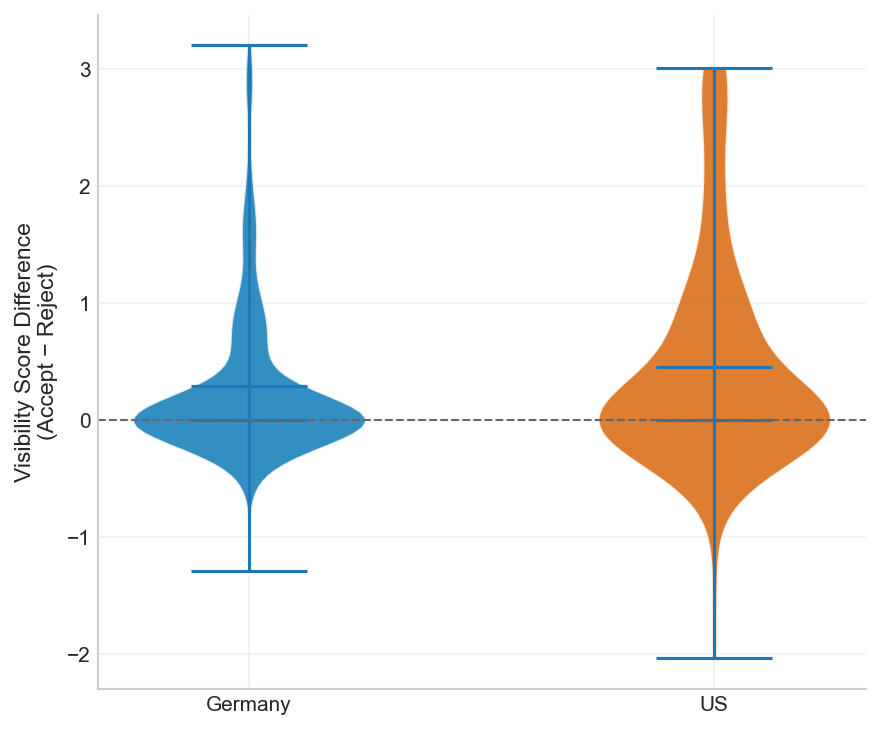

Germany: Mean diff = 0.29, Median = 0.00 (n=251)
US: Mean diff = 0.45, Median = 0.00 (n=101)
Positive = Accept more visible than Reject


In [ ]:
# Violin plot: Difference in visual prominence (Accept - Reject)
def get_vis_score_diff(df):
    """Calculate Accept minus Reject visibility score per website."""
    accept = df[df['category'] == 1].groupby('website_url')['vis_score'].max()
    reject = df[df['category'] == 2].groupby('website_url')['vis_score'].max()
    common = accept.index.intersection(reject.index)
    return accept[common] - reject[common]

eu_diff = get_vis_score_diff(df_eu_normalized_buttons)
us_diff = get_vis_score_diff(df_us_normalized_buttons)

fig, ax = plt.subplots(figsize=(6, 5))

# Create violin plot data
data = [eu_diff.dropna().values, us_diff.dropna().values]
positions = [0, 1]

parts = ax.violinplot(data, positions=positions, showmeans=True, showmedians=True)

# Color the violins
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor([COLORS['Germany'], COLORS['US']][i])
    pc.set_alpha(0.8)
    pc.set_edgecolor('white')

ax.axhline(y=0, color='#666666', linestyle='--', linewidth=1, label='Equal visibility')
ax.set_xticks(positions)
ax.set_xticklabels(['Germany', 'US'])
ax.set_ylabel('Visibility Score Difference\n(Accept − Reject)')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Germany: Mean diff = {eu_diff.mean():.2f}, Median = {eu_diff.median():.2f} (n={len(eu_diff)})")
print(f"US: Mean diff = {us_diff.mean():.2f}, Median = {us_diff.median():.2f} (n={len(us_diff)})")
print(f"Positive = Accept more visible than Reject")

## 6. Consent Management Platform (CMP) Analysis

**Question:** Do websites use different CMPs for US traffic versus Germany traffic?

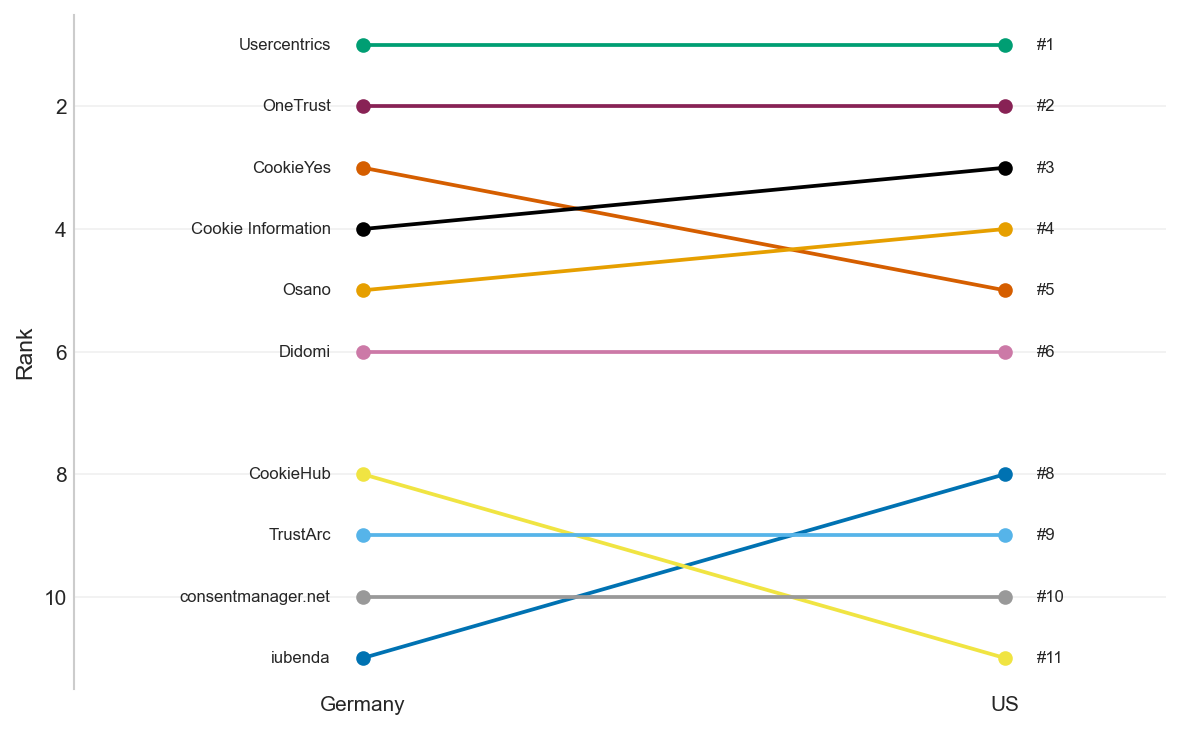

Top 5 CMPs by region:
Germany: ['Usercentrics', 'OneTrust', 'CookieYes', 'Cookie Information', 'Osano']
US: ['Usercentrics', 'OneTrust', 'Cookie Information', 'Osano', 'CookieYes']


In [ ]:
# Extract CMP data from raw records
def extract_cmps(records):
    """Extract CMP names from records."""
    cmps = []
    for record in records:
        url = record.get('url', '')
        cmp_data = record.get('data', {}).get('CMPGatherer', {})
        cmp_list = cmp_data.get('CMPs', [])
        
        for cmp in cmp_list:
            cmp_name = cmp.get('CMP_name', 'Unknown')
            cmps.append({'website': url, 'cmp': cmp_name})
    
    return pd.DataFrame(cmps)

eu_cmps = extract_cmps(eu_records)
us_cmps = extract_cmps(us_records)

# Get top 10 CMPs for each region
eu_cmp_counts = eu_cmps['cmp'].value_counts().head(10)
us_cmp_counts = us_cmps['cmp'].value_counts().head(10)

# Bump chart (ranking comparison)
fig, ax = plt.subplots(figsize=(8, 5))

# Get all CMPs that appear in top 10 of either region
all_top_cmps = list(set(eu_cmp_counts.index) | set(us_cmp_counts.index))

# Calculate ranks
eu_ranks = {cmp: i+1 for i, cmp in enumerate(eu_cmp_counts.index)}
us_ranks = {cmp: i+1 for i, cmp in enumerate(us_cmp_counts.index)}

# Colorblind-friendly palette (extended Okabe-Ito)
cmp_colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#F0E442', 
              '#56B4E9', '#E69F00', '#999999', '#000000', '#882255']

for i, cmp in enumerate(all_top_cmps[:10]):
    eu_rank = eu_ranks.get(cmp, 11)
    us_rank = us_ranks.get(cmp, 11)
    
    ax.plot([0, 1], [eu_rank, us_rank], 'o-', linewidth=1.8, markersize=6, 
            color=cmp_colors[i % len(cmp_colors)])
    ax.text(-0.05, eu_rank, cmp[:18], ha='right', va='center', fontsize=8)
    ax.text(1.05, us_rank, f'#{us_rank}', ha='left', va='center', fontsize=8)

ax.set_xlim(-0.45, 1.25)
ax.set_ylim(11.5, 0.5)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Germany', 'US'])
ax.set_ylabel('Rank')
ax.spines['bottom'].set_visible(False)
ax.grid(axis='x', visible=False)

plt.tight_layout()
plt.show()

print("Top 5 CMPs by region:")
print(f"Germany: {list(eu_cmp_counts.head(5).index)}")
print(f"US: {list(us_cmp_counts.head(5).index)}")